## BaarleNet [Part 1]

Semi-fresh start here as I get really going on part 3!

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os

In [2]:
# Set random seed for reproducibility
random_seed=25
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [3]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

In [4]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en.svg.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<10
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

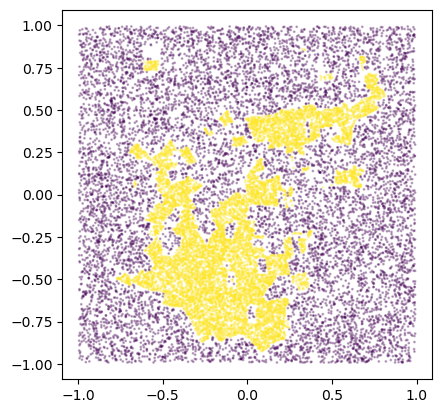

In [5]:
plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');

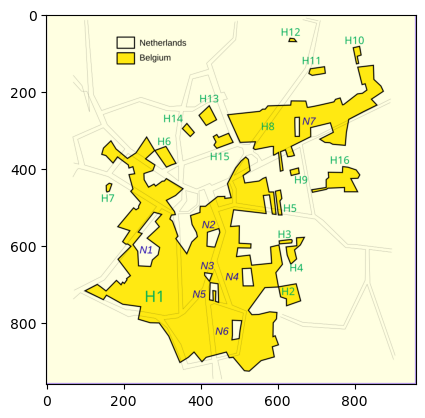

In [6]:
plt.imshow(map)

In [7]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
save_dir='may_20_2'
os.makedirs(save_dir, exist_ok=True)

In [9]:
X.shape

(20000, 2)

- BaarleNet([16, 16, 16, 16]), num_epochs = 10000, batch, Accuracy: 0.9546
- BaarleNet([16, 16, 16, 16]), num_epochs = 10000, stochastic, Accuracy: 0.8749
- BaarleNet([64, 64, 64, 64]), num_epochs = 10000, batch, Accuracy: 0.9810 <- starts to get some nice fine structure

In [12]:
torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([64, 64, 64, 64])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

num_epochs = 10000
for epoch in range(num_epochs):
    # Batch
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    #Stochastic
    # outputs = model(torch.tensor(X[epoch%len(y)]).float())
    # loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//25) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [400/10000], Loss: 0.1681, Accuracy: 0.9381
Epoch [800/10000], Loss: 0.1234, Accuracy: 0.9520
Epoch [1200/10000], Loss: 0.1069, Accuracy: 0.9618
Epoch [1600/10000], Loss: 0.0502, Accuracy: 0.9806
Epoch [2000/10000], Loss: 0.0375, Accuracy: 0.9870
Epoch [2400/10000], Loss: 0.0315, Accuracy: 0.9898
Epoch [2800/10000], Loss: 0.0600, Accuracy: 0.9727
Epoch [3200/10000], Loss: 0.0423, Accuracy: 0.9859
Epoch [3600/10000], Loss: 0.1107, Accuracy: 0.9608
Epoch [4000/10000], Loss: 0.0357, Accuracy: 0.9872
Epoch [4400/10000], Loss: 0.0330, Accuracy: 0.9878
Epoch [4800/10000], Loss: 0.0366, Accuracy: 0.9871
Epoch [5200/10000], Loss: 0.0252, Accuracy: 0.9912
Epoch [5600/10000], Loss: 0.0865, Accuracy: 0.9662
Epoch [6000/10000], Loss: 0.0698, Accuracy: 0.9732
Epoch [6400/10000], Loss: 0.0459, Accuracy: 0.9822
Epoch [6800/10000], Loss: 0.0366, Accuracy: 0.9855
Epoch [7200/10000], Loss: 0.0346, Accuracy: 0.9860
Epoch [7600/10000], Loss: 0.0645, Accuracy: 0.9748
Epoch [8000/10000], Loss: 0.0490,

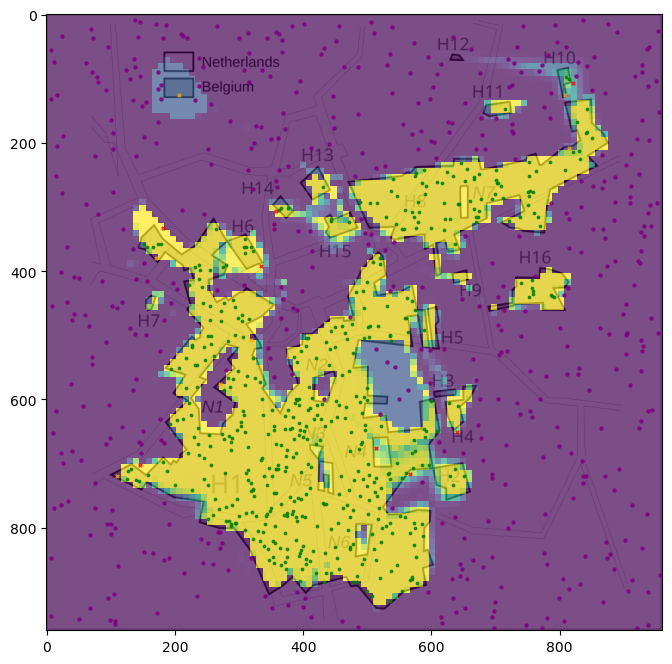

In [13]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)
viz_map_with_predictions(ax, map, X, y)

----

In [ ]:
probe=np.zeros((100,100,2))
for i, xx in enumerate(np.linspace(-1, 1, 100)):
    for j, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[i, j]=[xx,yy]
probe=probe.reshape(100**2, -1)

probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
plt.imshow(np.flipud(probe_logits[:,:,0]))

- Need a bit better output viz here I think to really see what's going on
- I do think that I can do some cool visual/animation stuff here with composing ReLUs!

In [ ]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)
viz_map_with_predictions(ax, map, X, y)

In [ ]:
probe_softmax.shape

In [ ]:
probe_softmax[:,0]>0.5

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');